In [7]:
import os
import random
import shutil

# Set up directories
base_dir = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
for directory in [train_dir, validation_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'images'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'masks'), exist_ok=True)

# Get list of image files
image_files = [f"{i}.png" for i in range(101, 246)]
random.shuffle(image_files)

# Define split percentages
train_split = 0.7
validation_split = 0.15
test_split = 0.15

# Calculate split sizes
num_samples = len(image_files)
num_train = int(train_split * num_samples)
num_validation = int(validation_split * num_samples)

# Split data
train_files = image_files[:num_train]
validation_files = image_files[num_train:num_train + num_validation]
test_files = image_files[num_train + num_validation:]

# Move files to appropriate directories
def move_files(files, source_dir, dest_dir):
    for file in files:
        # Move image
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, 'images', file))
        # Move corresponding masks
        mask_basename = os.path.splitext(file)[0]
        mask_files = [mask_basename + f"_{i}.png" for i in range(1, 12)]  # Assuming maximum of 5 masks per image
        for mask_file in mask_files:
            if os.path.exists(os.path.join(source_dir, mask_file)):
                shutil.move(os.path.join(source_dir, mask_file), os.path.join(dest_dir, 'masks', mask_file))

move_files(train_files, base_dir, train_dir)
move_files(validation_files, base_dir, validation_dir)
move_files(test_files, base_dir, test_dir)


In [99]:
from PIL import Image
import os

# Function to resize image and mask
def resize_image_and_mask(image_path, mask_path, target_size):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Resize image and mask
    image = image.resize(target_size, Image.ANTIALIAS)
    mask = mask.resize(target_size, Image.ANTIALIAS)

    return image, mask

# Set directory paths
base_dir = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define target size
target_size = (256, 256)

# Resize images and masks in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        mask_name = image_name.replace('.png', '_superimposed.png')  # Assuming masks have same filename with '_mask' suffix
        mask_path = os.path.join(class_dir, mask_name)
        
        # Resize image and mask
        resized_image, resized_mask = resize_image_and_mask(image_path, mask_path, target_size)
        
        # Save resized image and mask
        resized_image.save(image_path)
        resized_mask.save(mask_path)

# Repeat the same process for validation and test directories
# (Assuming the structure is similar)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\David\\Documents\\UofT\\1433\\UofTset\\Dataset\\train\\images\\101_superimposed.png'

In [100]:
# Directory paths
train_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\train\images'
val_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\validation\images'
test_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\test\images'

# Define function to load images and masks
def load_images_and_masks(directory):
    mask_directory = directory.replace('images', 'masks')  # Adjust to get the corresponding masks directory
    image_paths = sorted([os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_directory, fname) for fname in os.listdir(mask_directory) if fname.endswith('.png')])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_height, image_width))
        mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale', target_size=(image_height, image_width))

        images.append(tf.keras.preprocessing.image.img_to_array(image) / 255.0)  # Normalize images
        masks.append(tf.keras.preprocessing.image.img_to_array(mask) / 255.0)    # Normalize masks

    return np.array(images), np.array(masks)

# Load images and masks for train, validation, and test sets
train_images, train_masks = load_images_and_masks(train_dir_images)
val_images, val_masks = load_images_and_masks(val_dir_images)
test_images, test_masks = load_images_and_masks(test_dir_images)


In [96]:
import os
import numpy as np
from PIL import Image

def superimpose_masks_and_save(mask_dir, prefix, output_dir):
    mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir) if filename.startswith(prefix)]
    if not mask_paths:
        return  # Skip if no masks found for the prefix
    superimposed_mask = None
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path).convert('L').resize((256, 256)))
        if superimposed_mask is None:
            superimposed_mask = mask
        else:
            superimposed_mask = np.maximum(superimposed_mask, mask)
    # Save the superimposed mask to the output directory
    output_path = os.path.join(output_dir, prefix + '_superimposed.png')
    superimposed_mask_image = Image.fromarray(superimposed_mask)
    superimposed_mask_image.save(output_path)

def process_directory(directory):
    mask_dir = os.path.join(directory, 'masks')
    output_dir = os.path.join(mask_dir, 'superimposed_masks')
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

    for i in range(101, 246):
        prefix = str(i) + '_'  # Change this to the desired prefix
        superimpose_masks_and_save(mask_dir, prefix, output_dir)

validation_dir = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\test'
process_directory(validation_dir)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_22[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9839 - loss: 0.1976 - val_accuracy: 0.9946 - val_loss: 0.0519
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 961ms/step - accuracy: 0.9937 - loss: 0.0552 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 964ms/step - accuracy: 0.9939 - loss: 0.0526 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 986ms/step - accuracy: 0.9936 - loss: 0.0554 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 986ms/step - accuracy: 0.9938 - loss: 0.0543 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 969ms/step - accuracy: 0.9931 - loss: 0.0622 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 963ms/step - accuracy: 0.9928 - loss: 0.0642 - val_accuracy: 0.9946 - val_loss: 0.0518
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 967ms/step - accuracy: 0.9930 - loss: 0.0622 - val_accuracy: 0.9946 - val_loss:

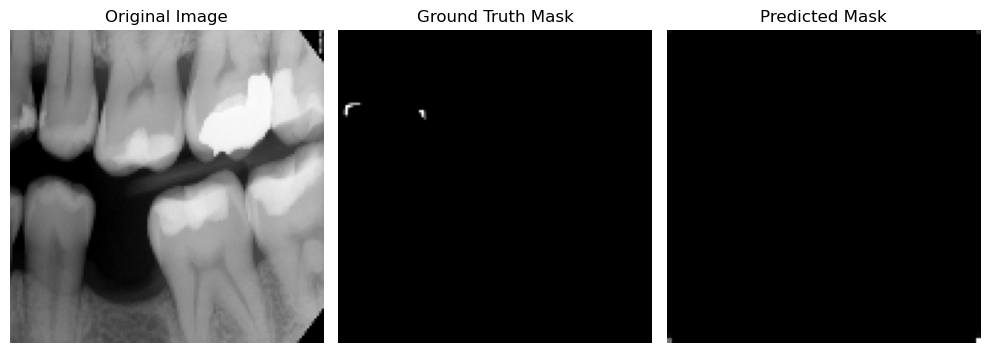

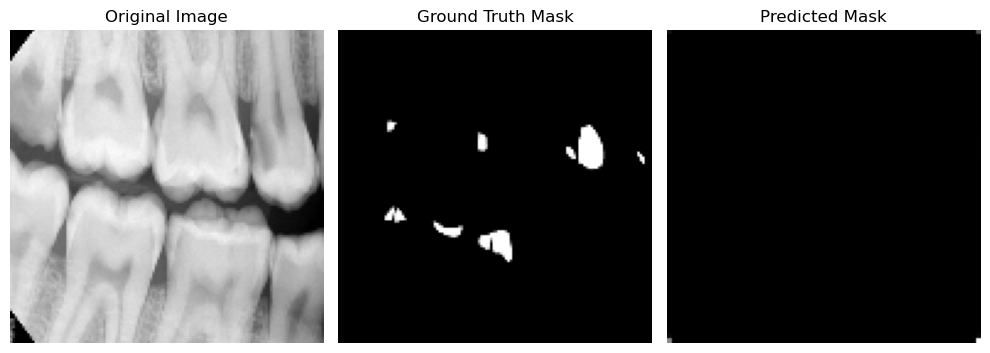

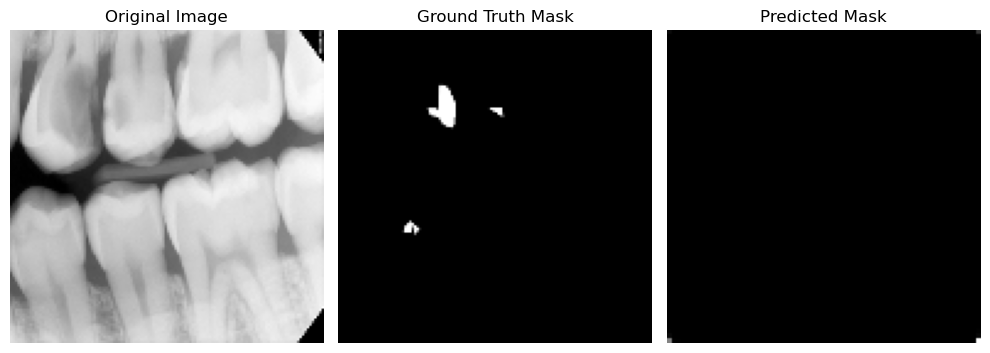

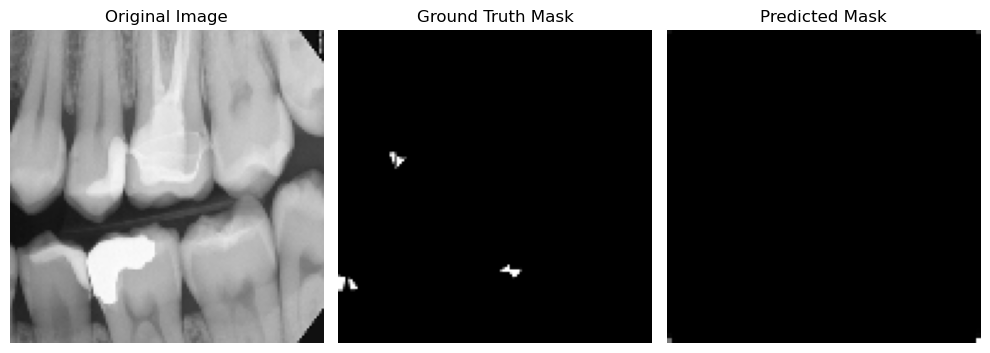

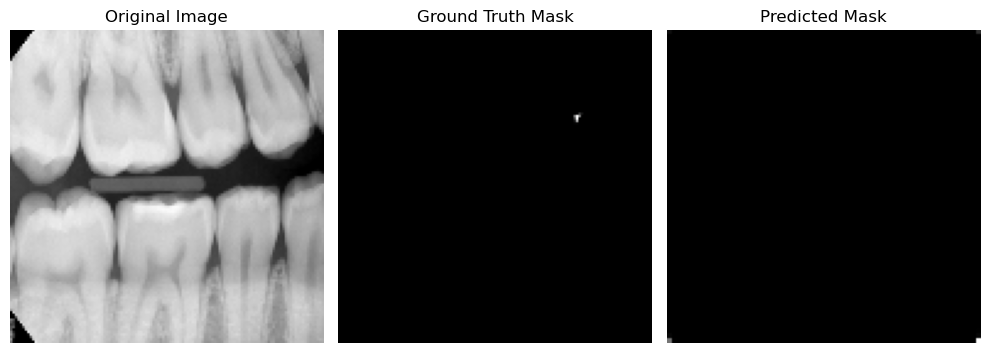

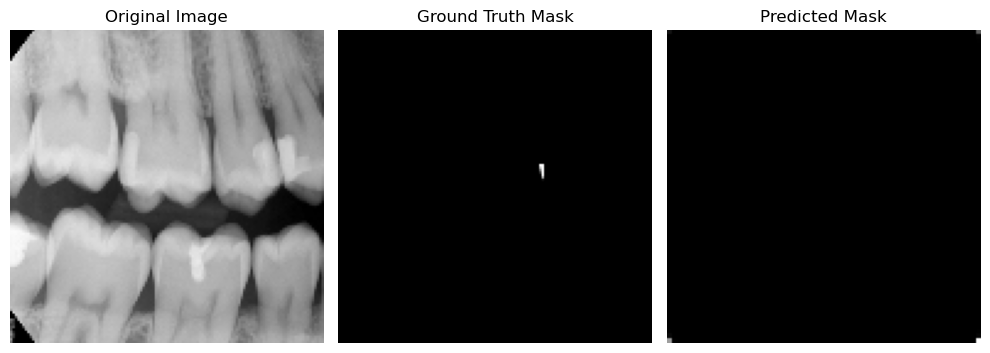

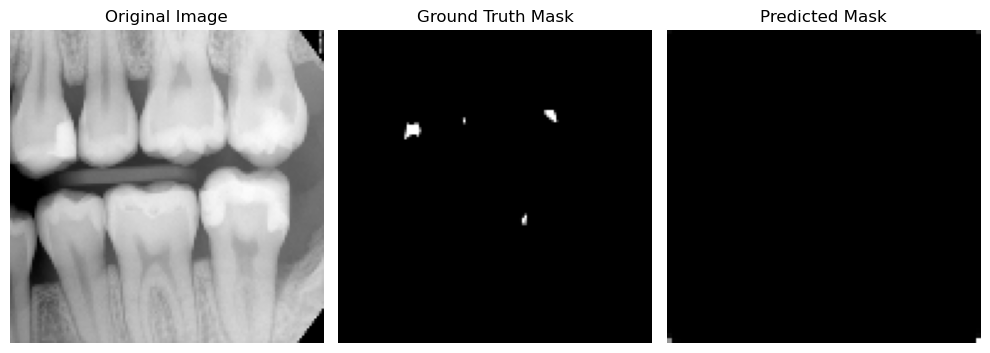

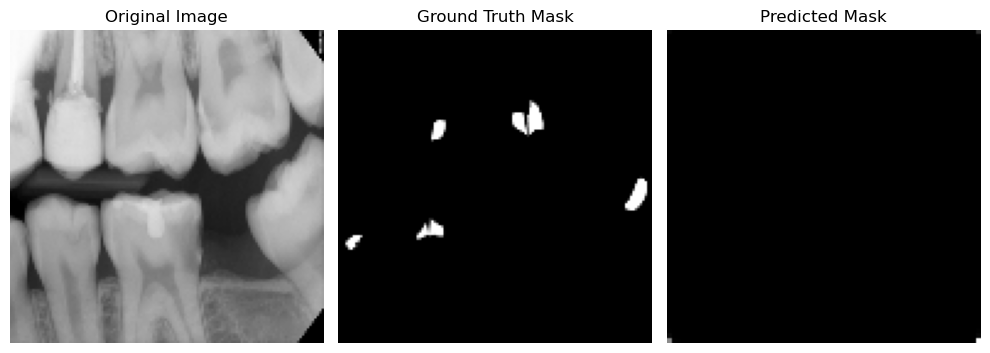

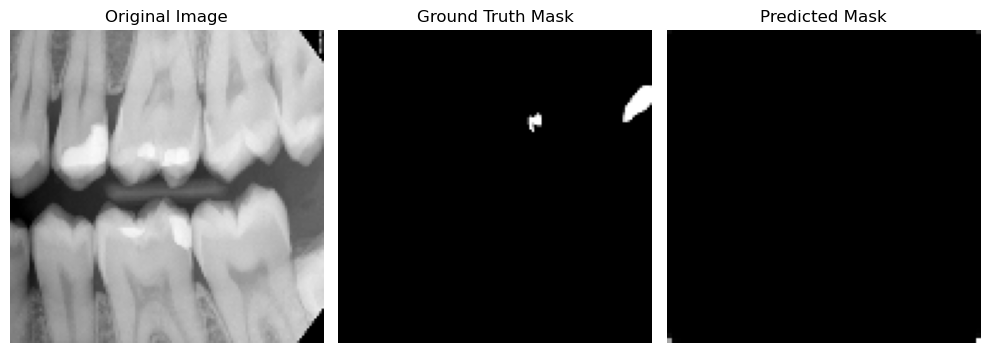

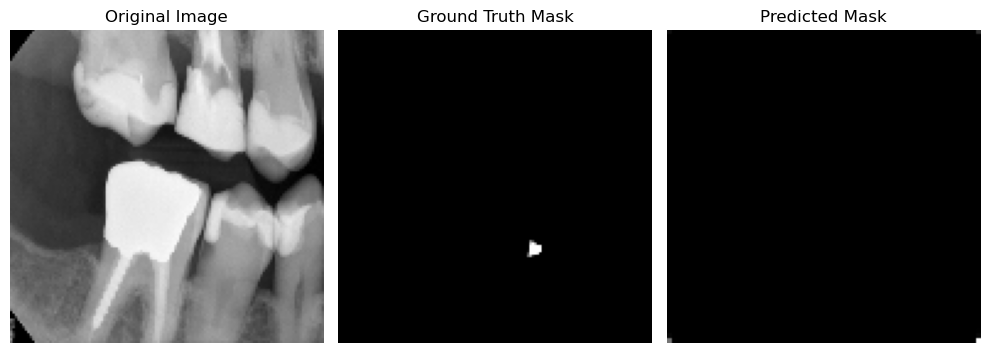

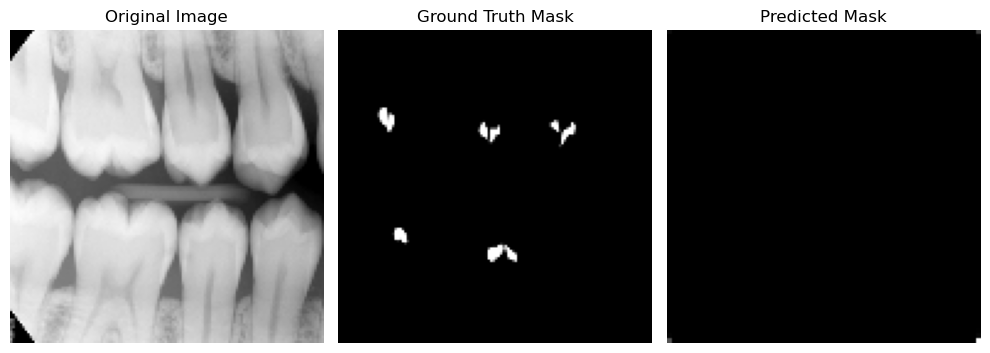

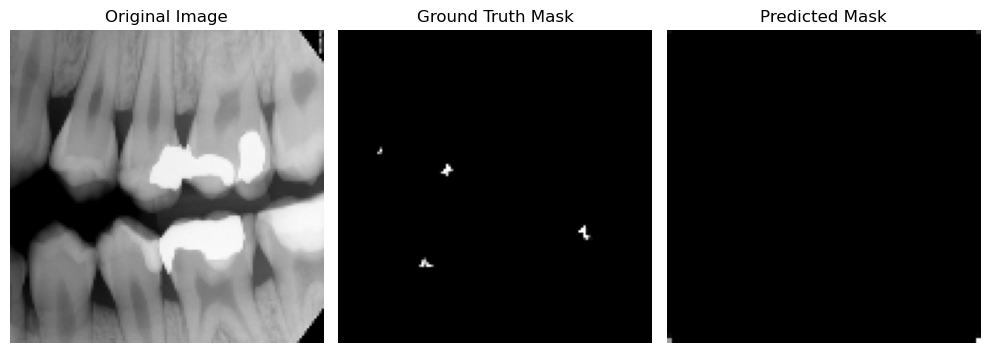

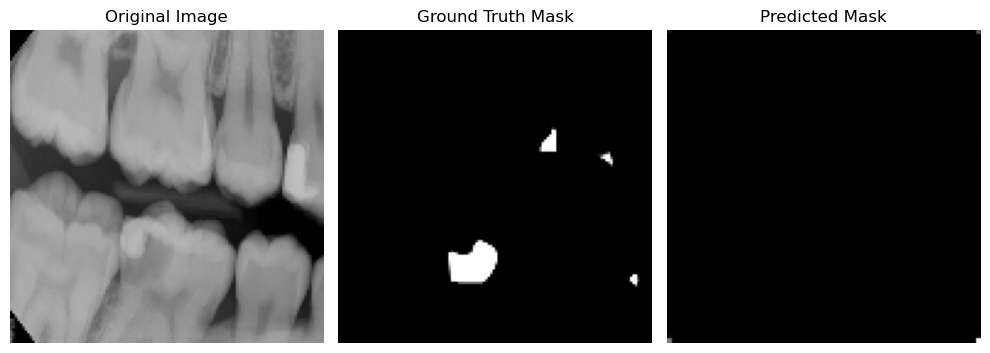

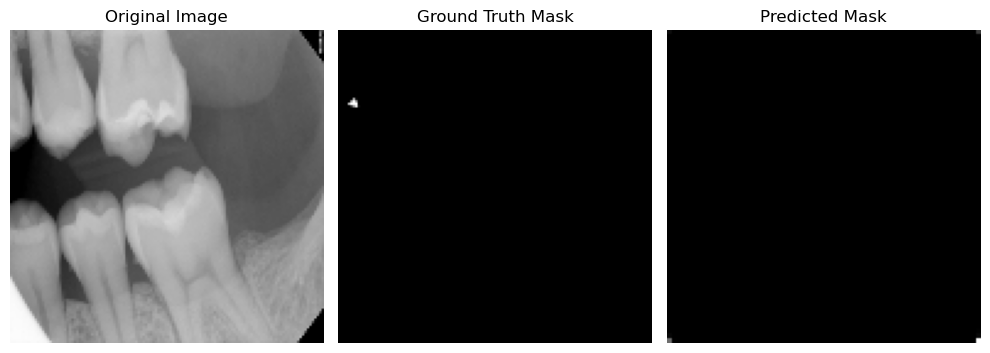

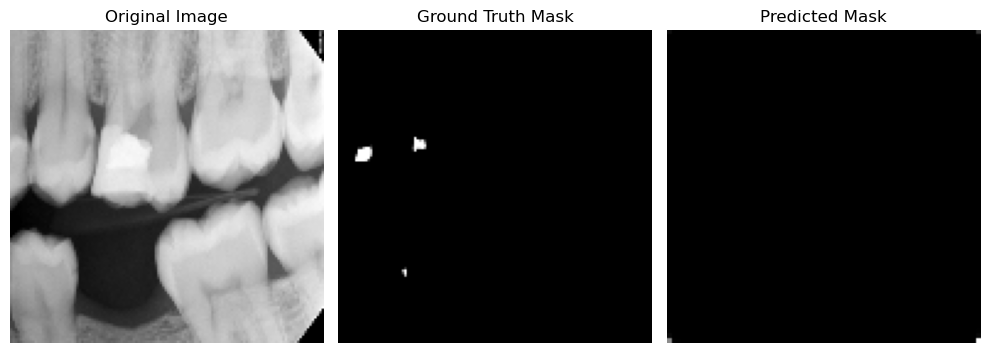

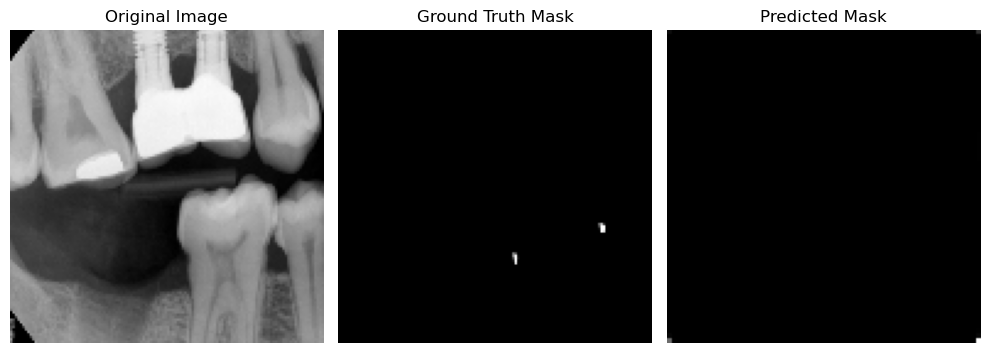

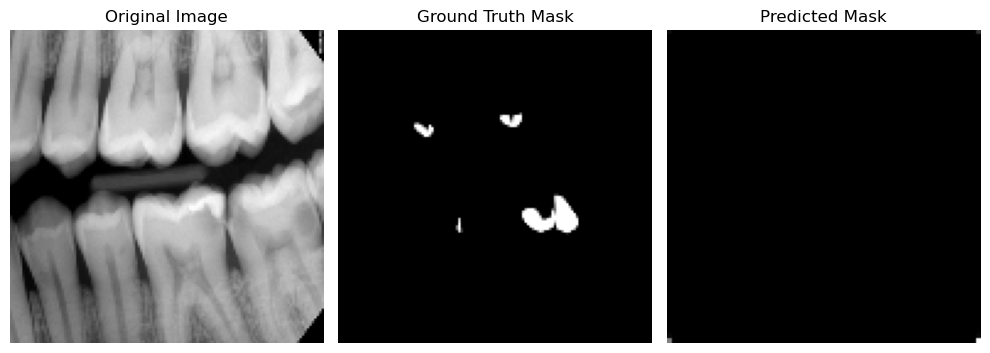

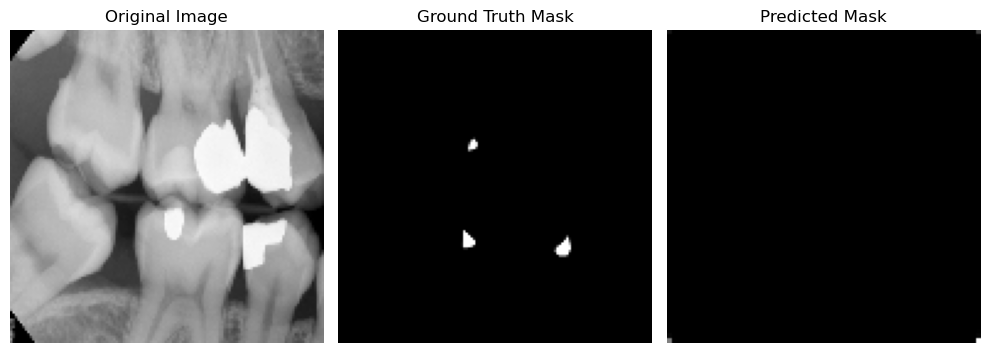

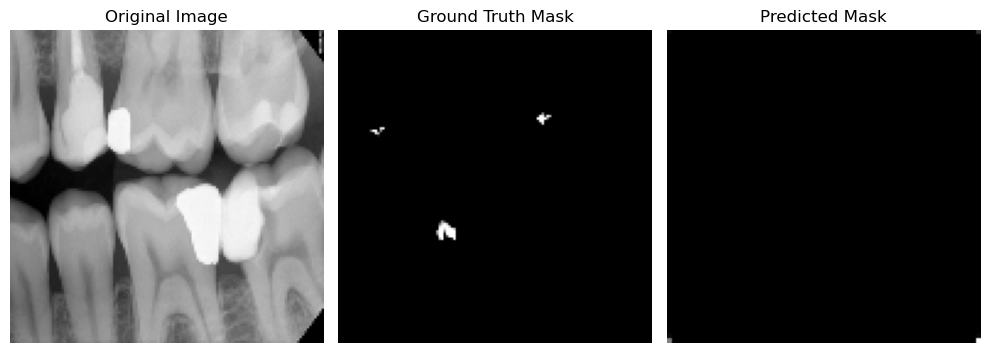

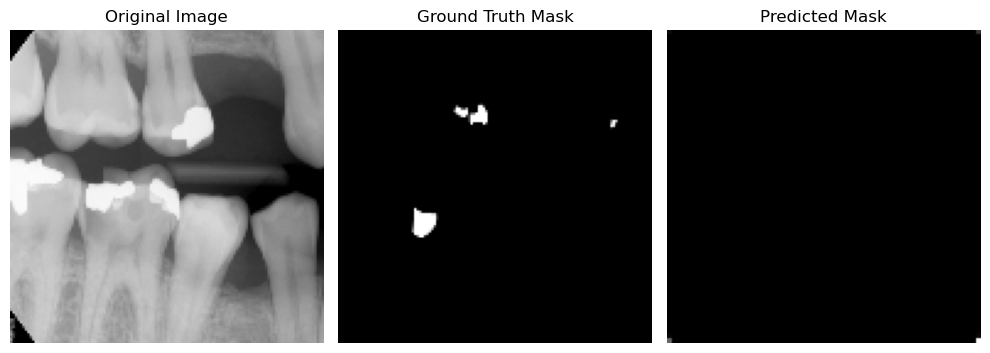

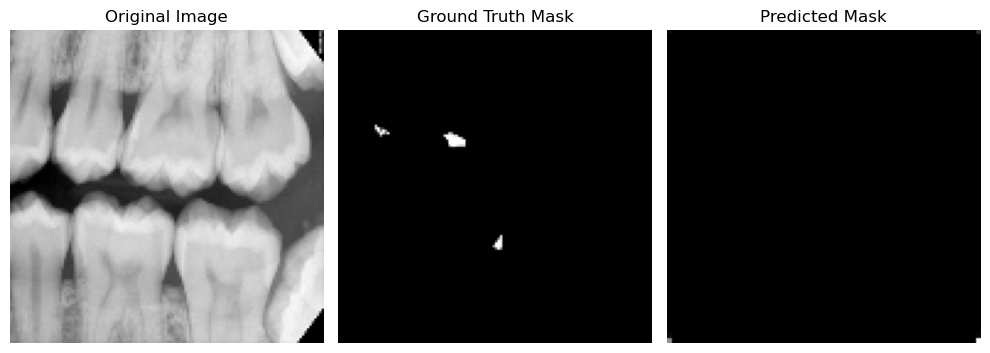

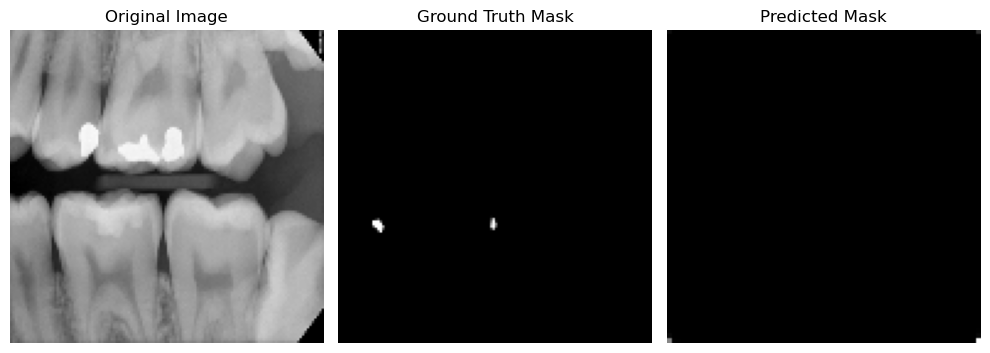

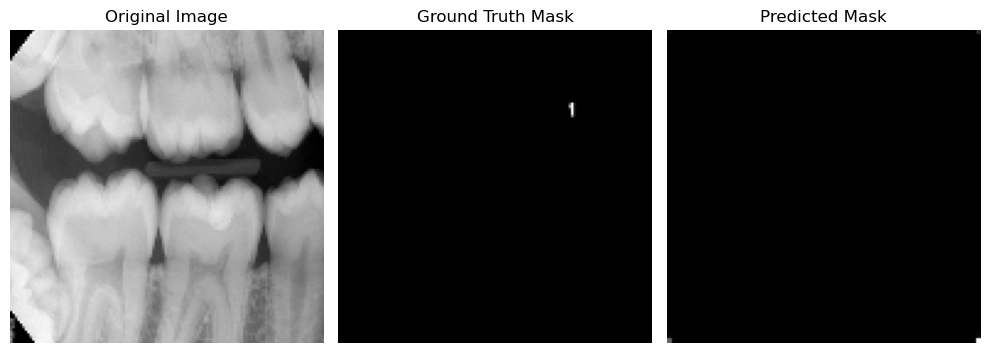

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Directory paths
train_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\train\images'
val_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\validation\images'
test_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\test\images'

# Define function to load images and masks
def load_images_and_masks(directory):
    mask_directory = directory.replace('images', 'masks')  # Adjust to get the corresponding masks directory
    image_paths = sorted([os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_directory, fname) for fname in os.listdir(mask_directory) if fname.endswith('.png')])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))  # Reduce input size
        mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale', target_size=(128, 128))  # Reduce input size

        images.append(tf.keras.preprocessing.image.img_to_array(image) / 255.0)  # Normalize images
        masks.append(tf.keras.preprocessing.image.img_to_array(mask) / 255.0)    # Normalize masks

    return np.array(images), np.array(masks)

# Load images and masks for train, validation, and test sets
train_images, train_masks = load_images_and_masks(train_dir_images)
val_images, val_masks = load_images_and_masks(val_dir_images)
test_images, test_masks = load_images_and_masks(test_dir_images)

# Define ResNet50-based segmentation model with a smaller input size
def create_segmentation_model(input_shape):
    # Load pre-trained ResNet50 model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze convolutional layers of ResNet50
    base_model.trainable = False

    segmentation_head = tf.keras.Sequential([
        layers.UpSampling2D(size=(4, 4)),  # Maintain upsampling factor
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D(size=(2, 2)), 
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D(size=(2, 2)), 
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        layers.UpSampling2D(size=(2, 2))
    ])

    # Combine base model with segmentation head
    model = models.Sequential([
        base_model,
        segmentation_head
    ])

    return model

# Create segmentation model
input_shape = (128, 128, 3)
segmentation_model = create_segmentation_model(input_shape)

# Compile the model
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
segmentation_model.summary()

# Display summary of the weights
segmentation_model.layers[0].summary()

# Training loop with reduced batch size
num_epochs = 15
batch_size = 16  # Reduced batch size
history = segmentation_model.fit(train_images, train_masks, epochs=num_epochs, batch_size=batch_size, validation_data=(val_images, val_masks))

# Evaluate the model on test set
test_loss, test_accuracy = segmentation_model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on test set
predictions = segmentation_model.predict(test_images)

import matplotlib.pyplot as plt

# Function to visualize ground truth and predicted masks for a single image
def visualize_masks(image, true_mask, predicted_mask):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize masks for all test images
for i in range(len(test_images)):
    visualize_masks(test_images[i], test_masks[i], predictions[i])



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_26 (Sequential)           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9937 - loss: 0.2880 - val_accuracy: 0.9946 - val_loss: 0.0666
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 992ms/step - accuracy: 0.9935 - loss: 0.0559 - val_accuracy: 0.9946 - val_loss: 0.0663
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9941 - loss: 0.0510 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9938 - loss: 0.0486 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1000ms/step - accuracy: 0.9944 - loss: 0.0474 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9939 - loss: 0.0528 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9933 - loss: 0.0627 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9940 - loss: 0.0494 - val_accuracy: 0.9946 - val_loss: 0.0662
Epoch 9/

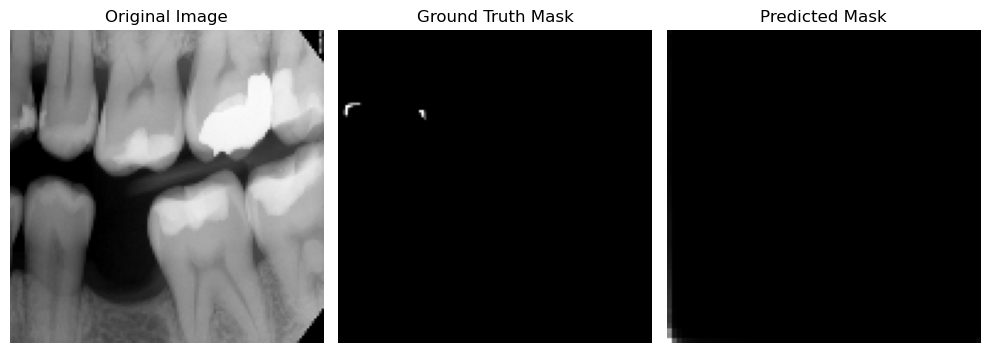

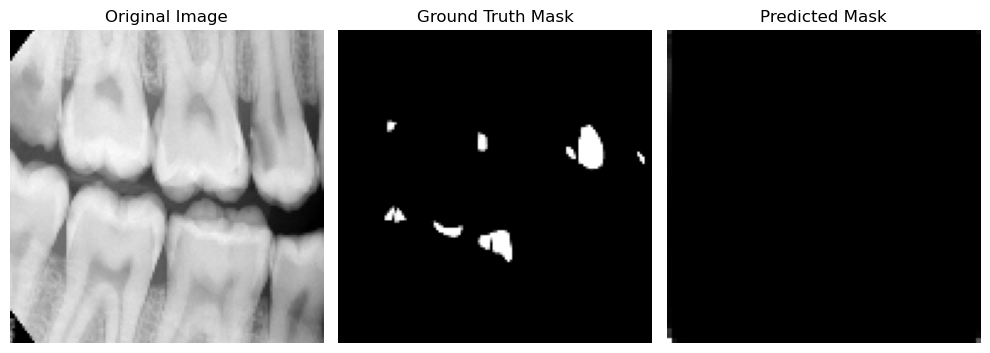

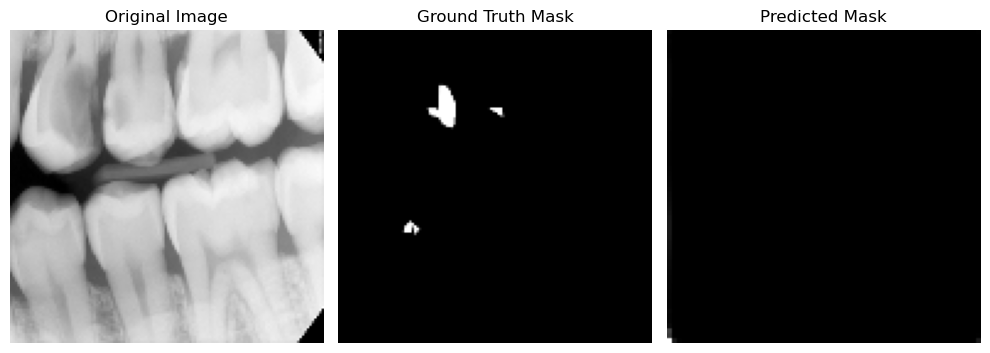

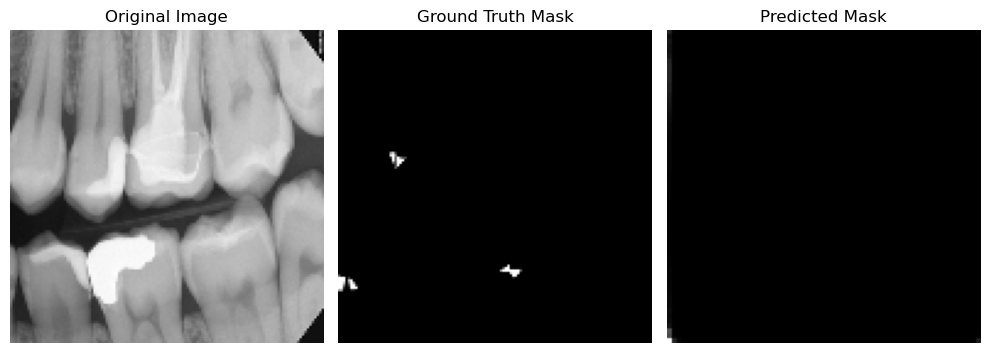

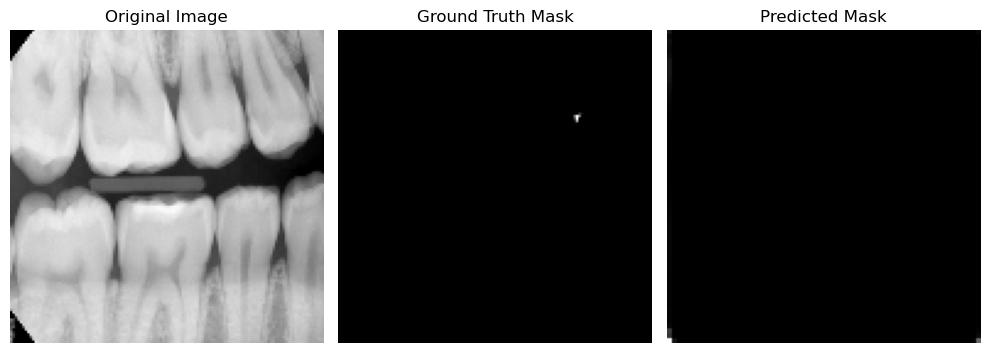

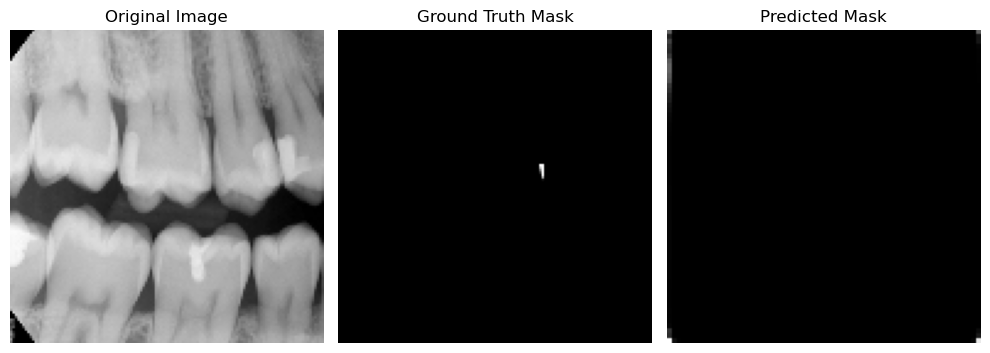

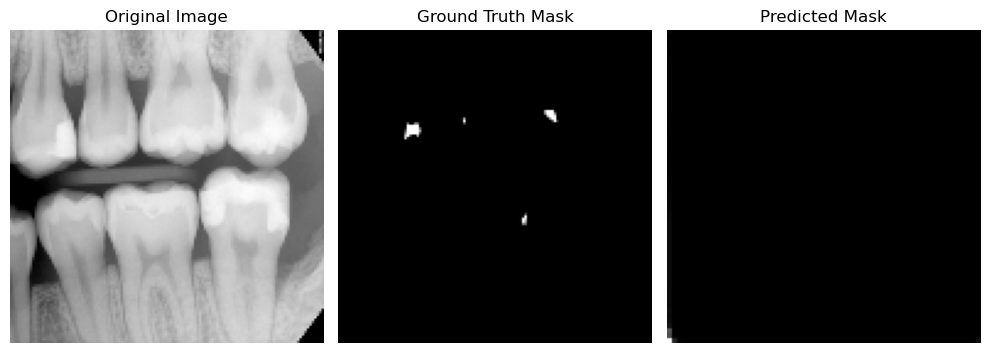

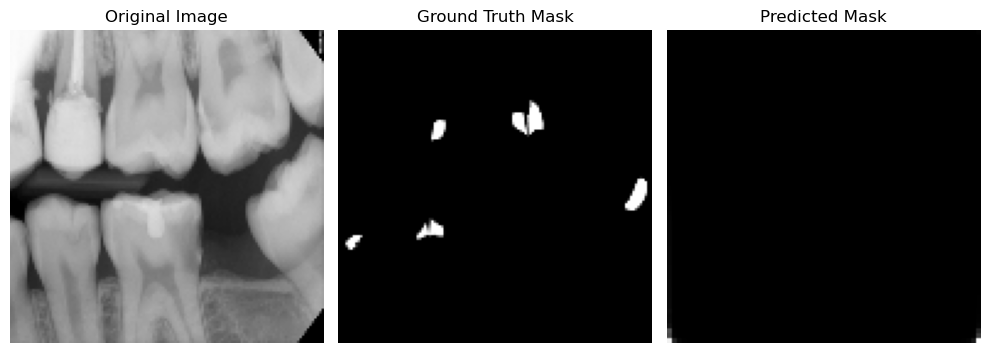

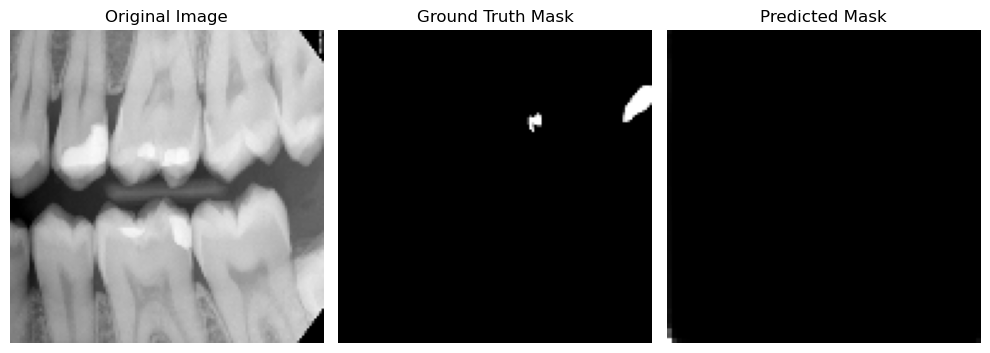

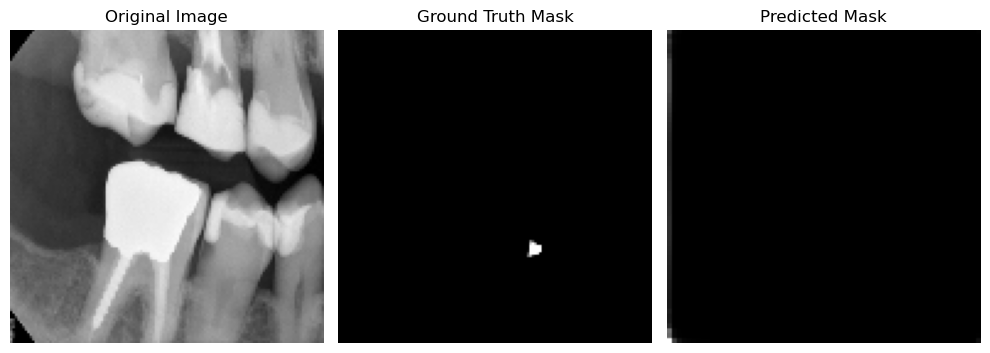

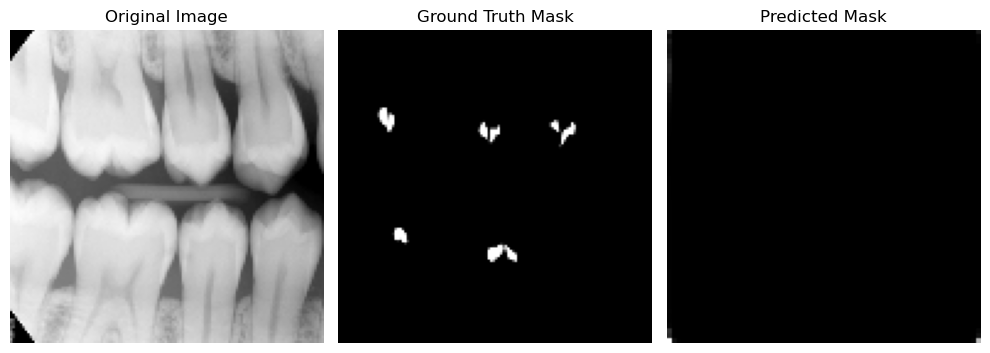

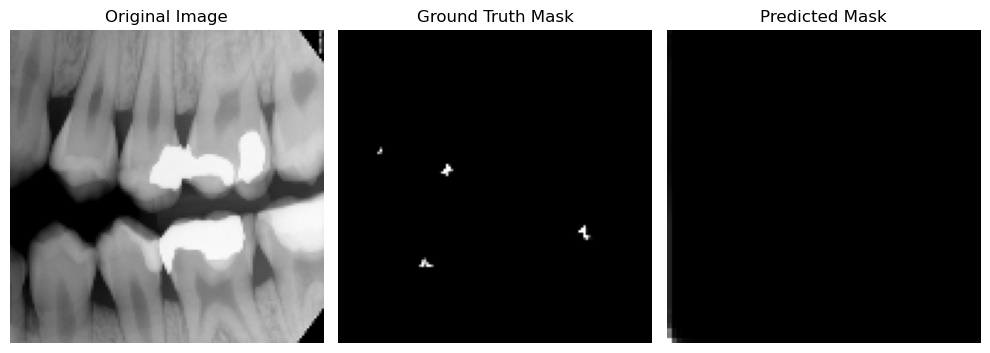

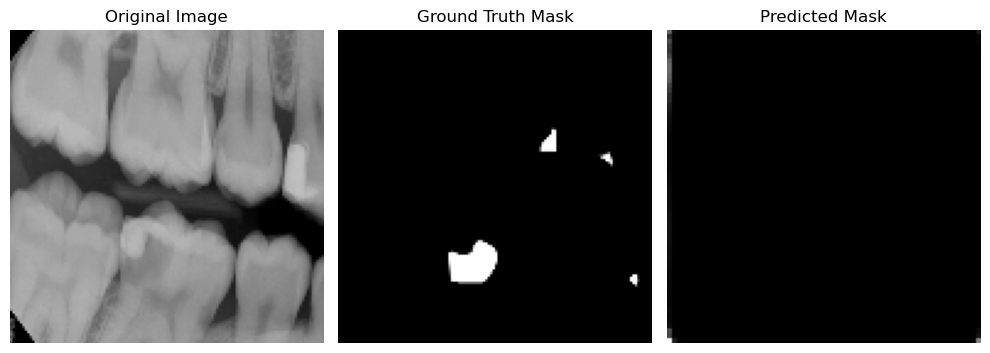

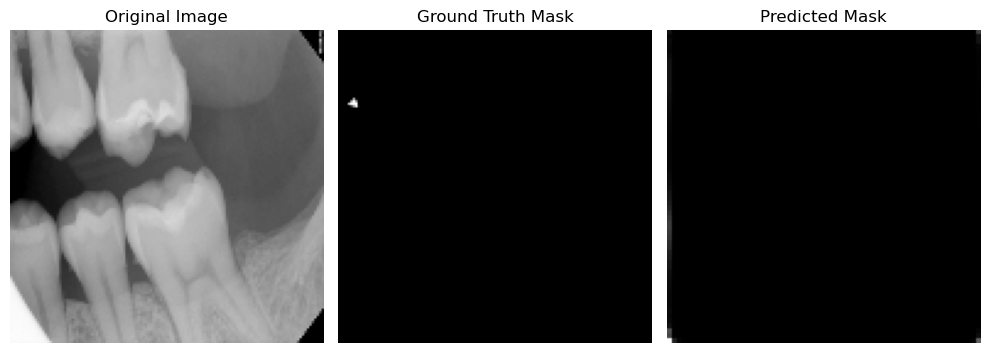

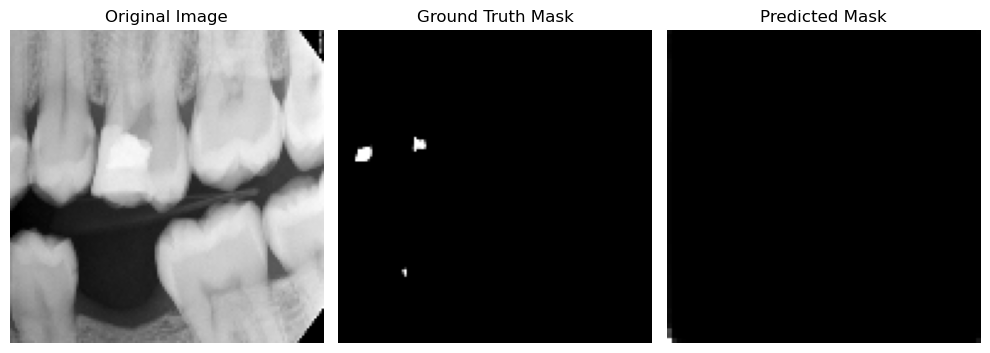

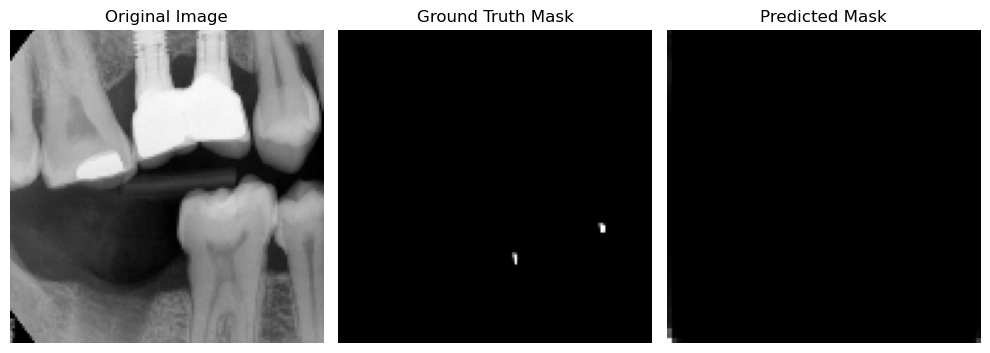

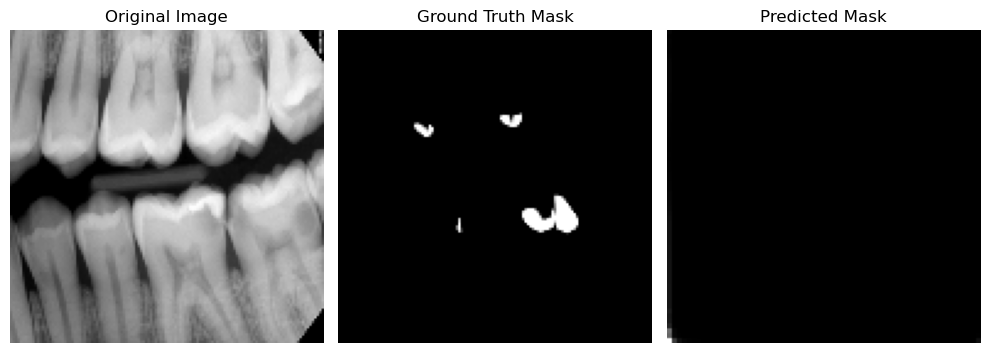

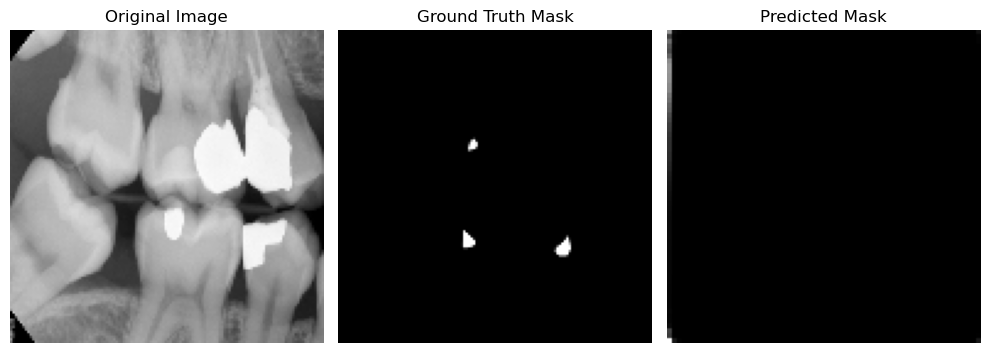

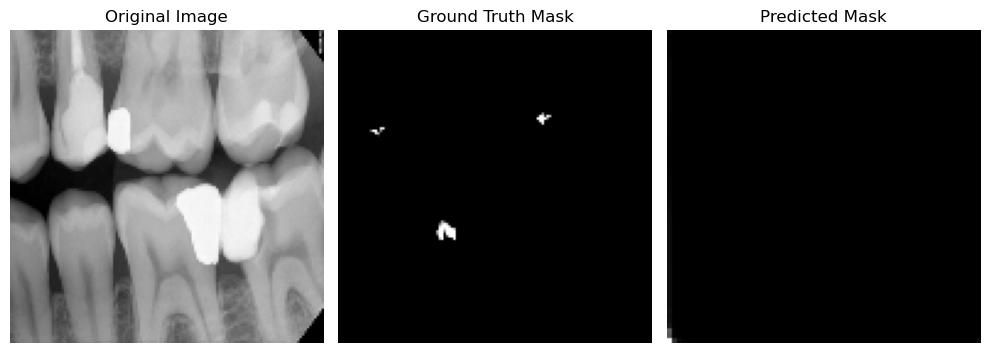

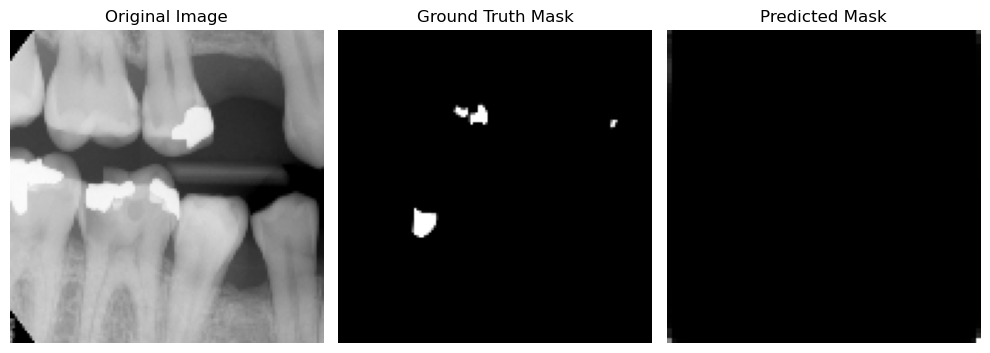

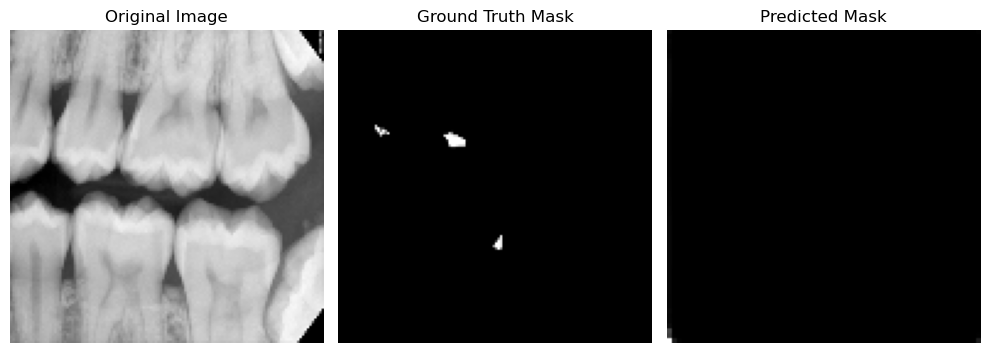

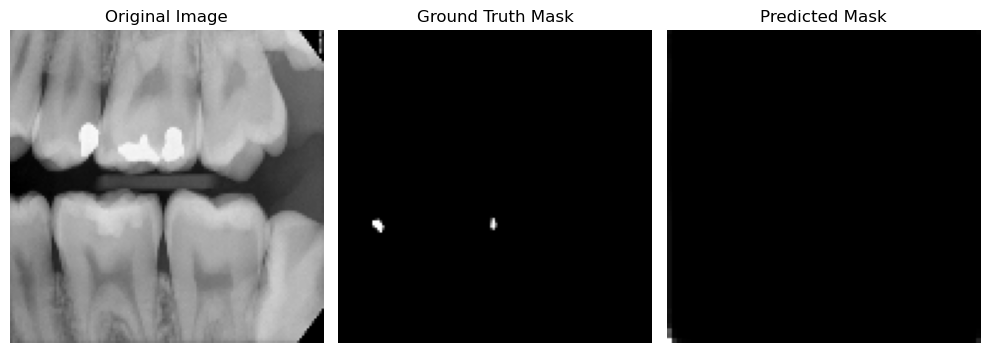

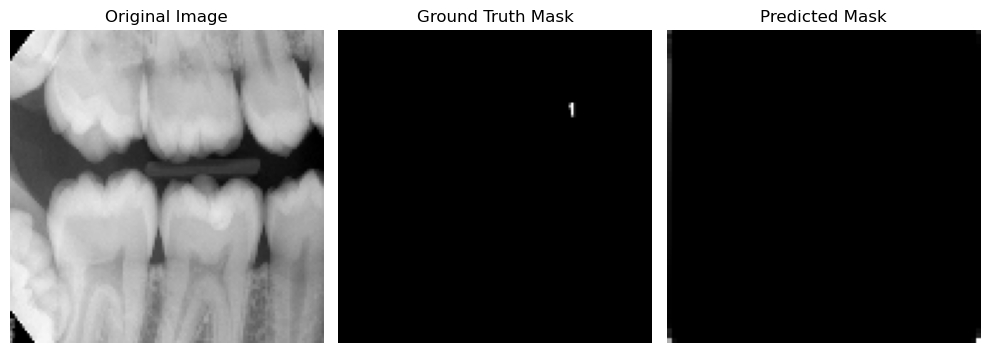

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Directory paths
train_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\train\images'
val_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\validation\images'
test_dir_images = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\test\images'

# Define function to load images and masks
def load_images_and_masks(directory):
    mask_directory = directory.replace('images', 'masks')  # Adjust to get the corresponding masks directory
    image_paths = sorted([os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_directory, fname) for fname in os.listdir(mask_directory) if fname.endswith('.png')])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))  # Reduce input size
        mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale', target_size=(128, 128))  # Reduce input size

        images.append(tf.keras.preprocessing.image.img_to_array(image) / 255.0)  # Normalize images
        masks.append(tf.keras.preprocessing.image.img_to_array(mask) / 255.0)    # Normalize masks

    return np.array(images), np.array(masks)

# Load images and masks for train, validation, and test sets
train_images, train_masks = load_images_and_masks(train_dir_images)
val_images, val_masks = load_images_and_masks(val_dir_images)
test_images, test_masks = load_images_and_masks(test_dir_images)

# Define ResNet50-based segmentation model with a smaller input size
def create_segmentation_model(input_shape):
    # Load pre-trained ResNet50 model
    base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)

    # Freeze convolutional layers of ResNet50
    base_model.trainable = False

    segmentation_head = tf.keras.Sequential([
        layers.UpSampling2D(size=(4, 4)),  # Maintain upsampling factor
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D(size=(2, 2)), 
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D(size=(2, 2)), 
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        layers.UpSampling2D(size=(2, 2))
    ])

    # Combine base model with segmentation head
    model = models.Sequential([
        base_model,
        segmentation_head
    ])

    return model

# Create segmentation model
input_shape = (128, 128, 3)
segmentation_model11 = create_segmentation_model(input_shape)

# Compile the model
segmentation_model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
segmentation_model11.summary()

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Create augmented data generator for train set
train_datagen = datagen.flow(train_images, train_masks, batch_size=16)

# Training loop with augmented data generator
num_epochs = 40
history = segmentation_model11.fit(train_datagen, epochs=num_epochs, validation_data=(val_images, val_masks))

# Evaluate the model on test set
test_loss, test_accuracy = segmentation_model11.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on test set
predictions1 = segmentation_model11.predict(test_images)

# Function to visualize ground truth and predicted masks for a single image
def visualize_masks(image, true_mask, predicted_mask):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize masks for all test images
for i in range(len(test_images)):
    visualize_masks(test_images[i], test_masks[i], predictions1[i])


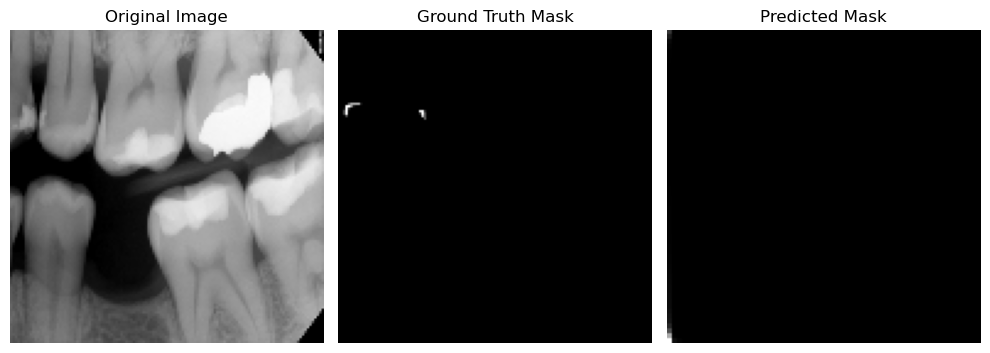

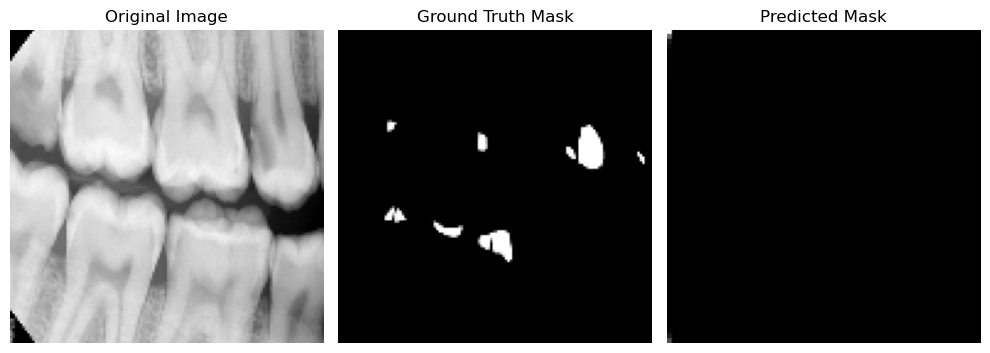

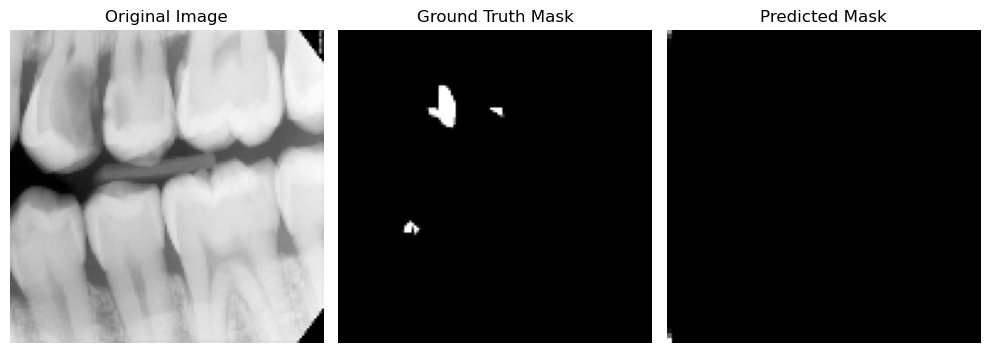

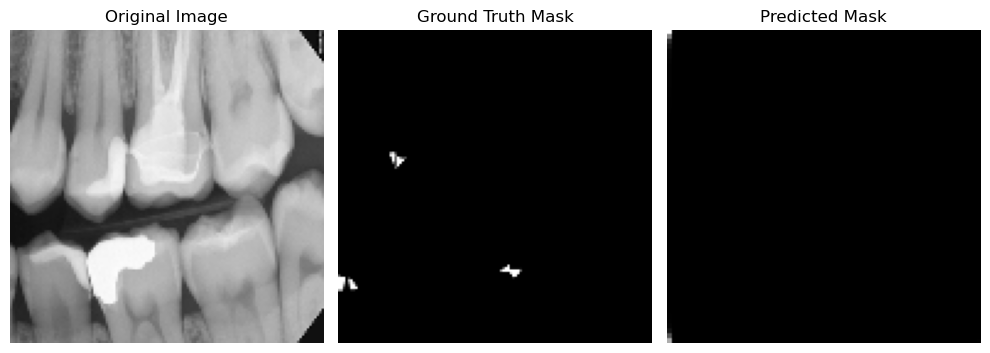

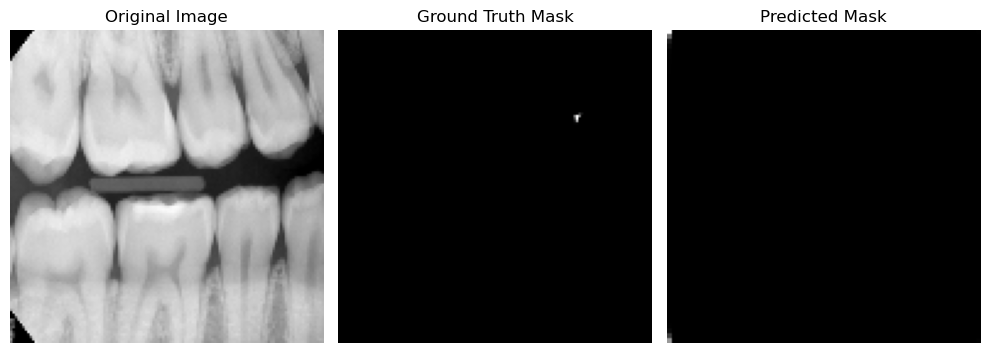

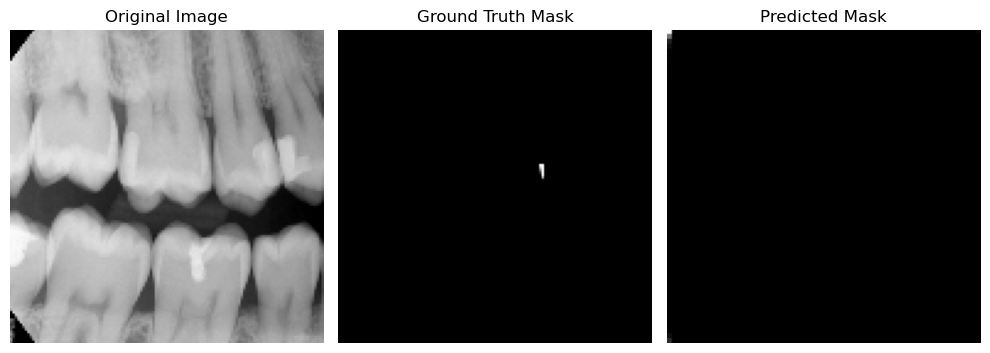

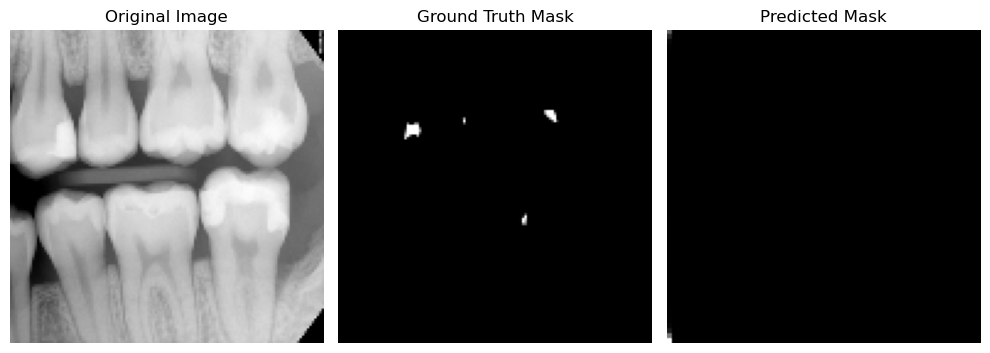

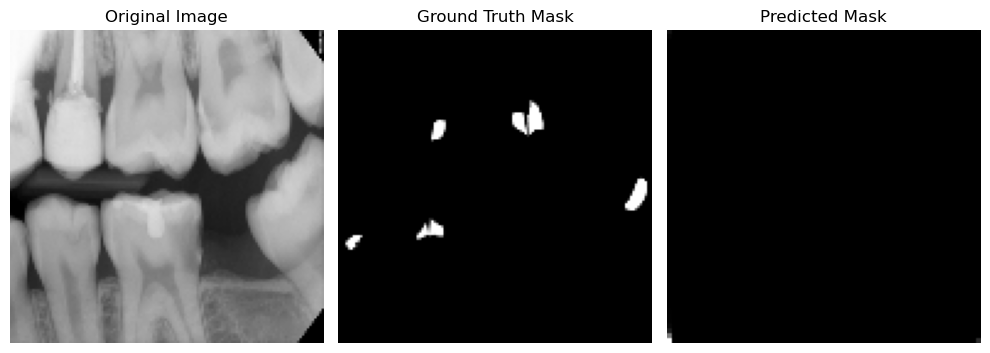

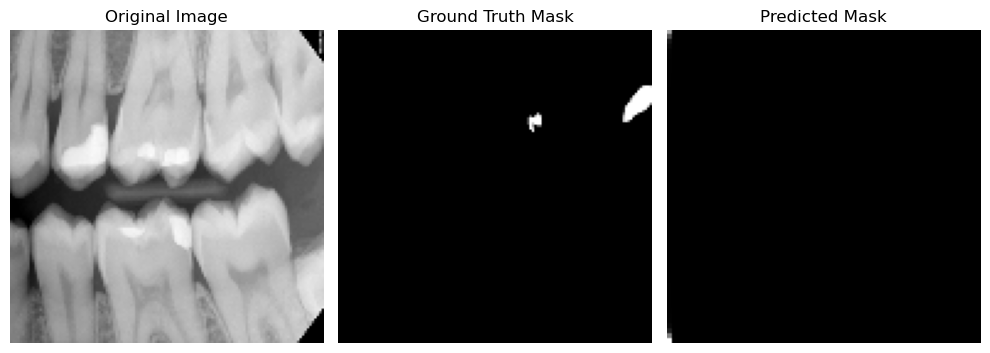

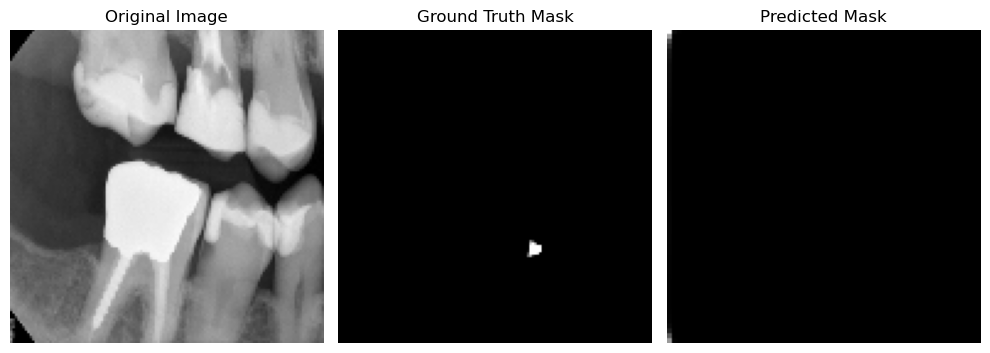

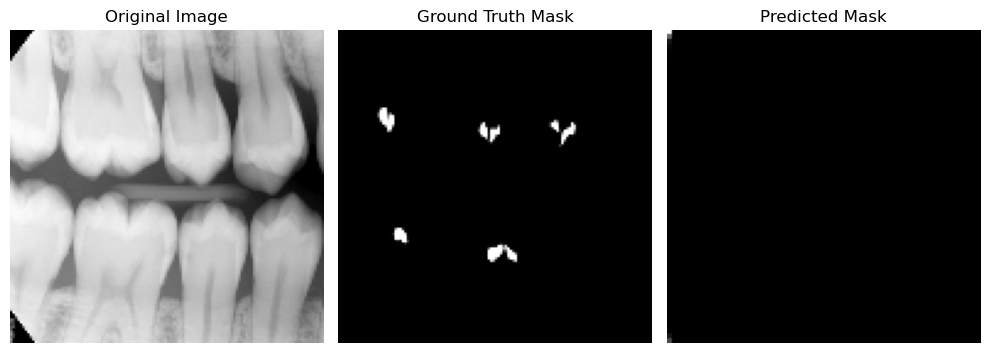

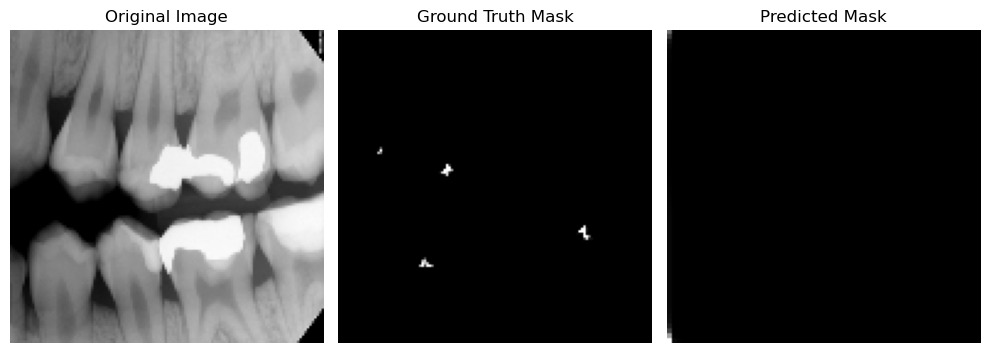

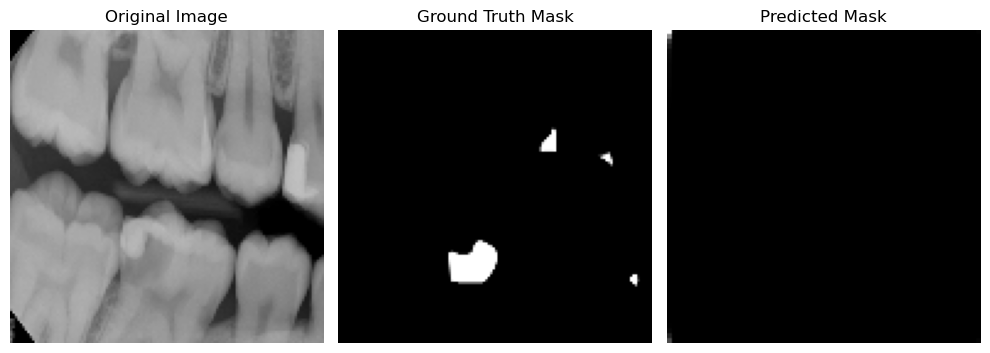

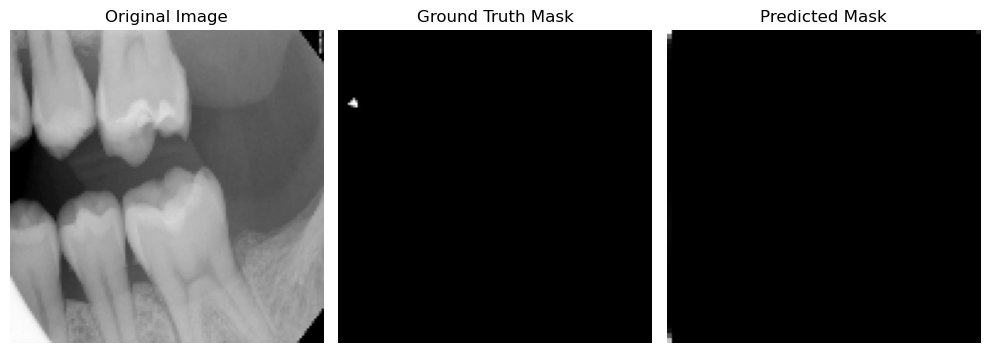

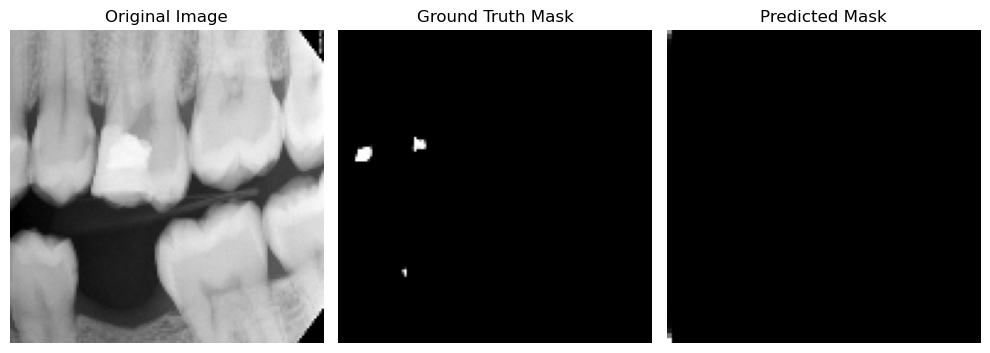

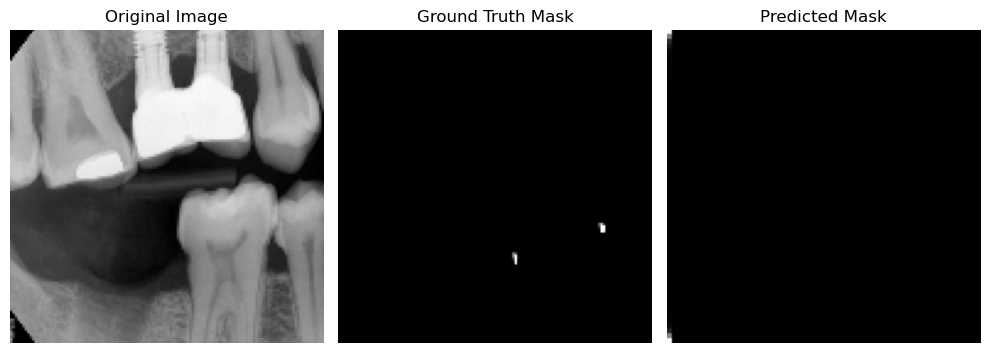

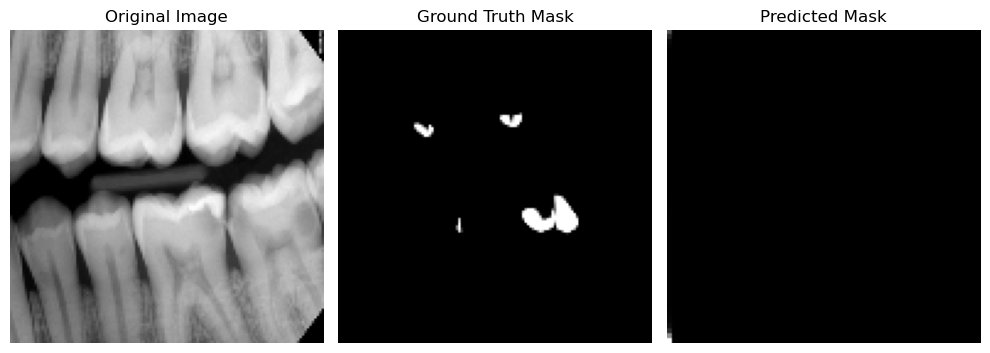

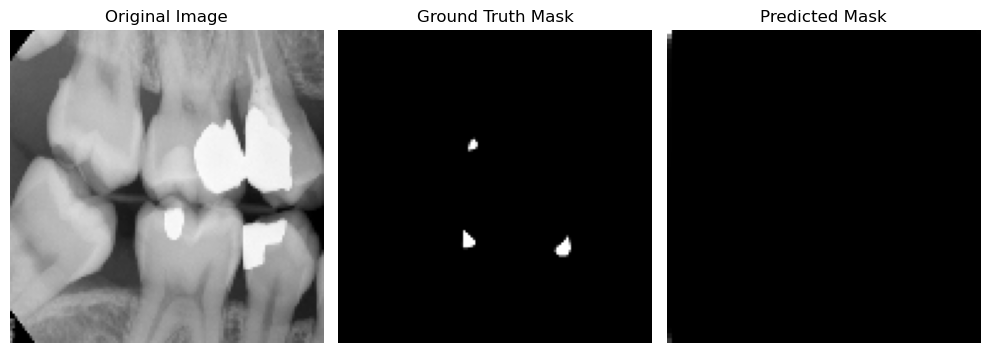

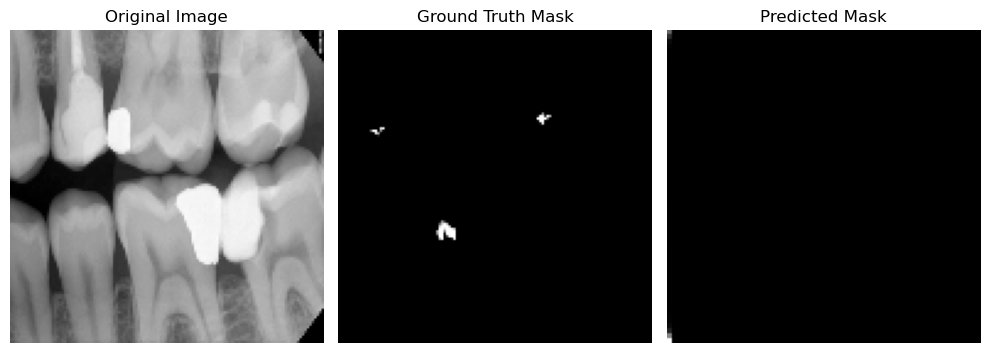

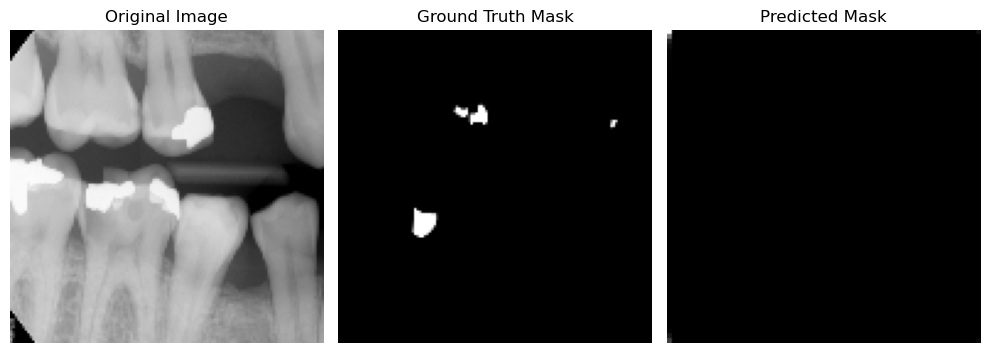

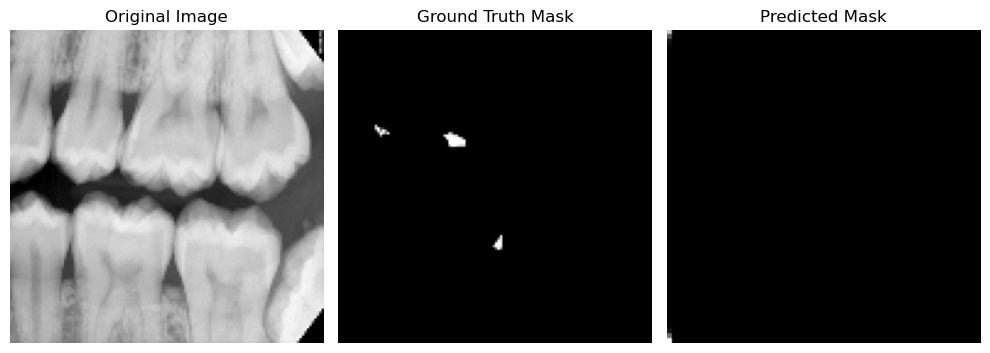

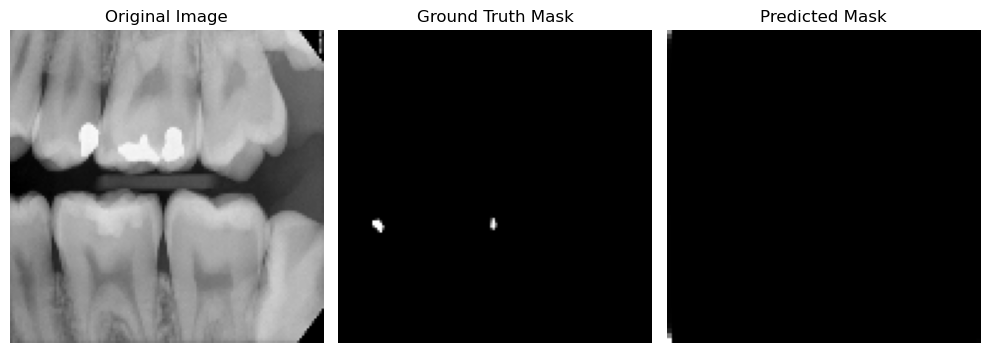

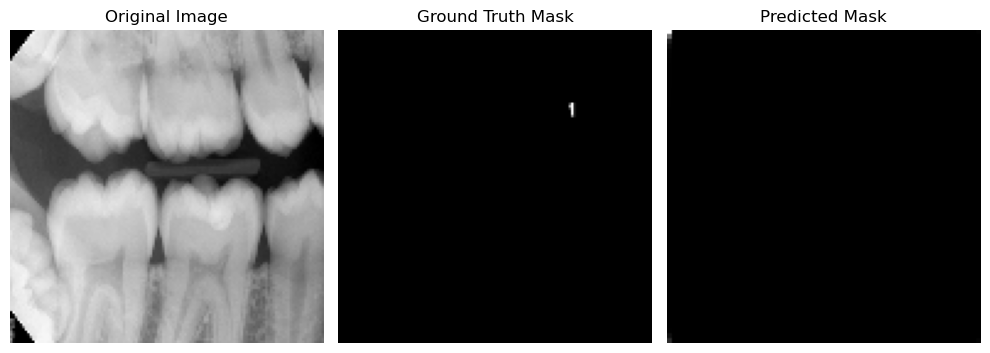

In [13]:
def visualize_masks(image, true_mask, predicted_mask):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize masks for all test images
for i in range(len(test_images)):
    visualize_masks(test_images[i], test_masks[i], predictions[i])


In [173]:
import os
from PIL import Image

# Directory containing the images to resize
image_directory = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\test\images'

# Resize images in the input directory and overwrite them
for filename in os.listdir(image_directory):
    if filename.endswith('.png'):
        # Open the image
        image_path = os.path.join(image_directory, filename)
        img = Image.open(image_path)
        
        # Resize the image to 256x256 pixels
        img_resized = img.resize((256, 256), Image.ANTIALIAS)
        
        # Overwrite the original image with the resized image
        img_resized.save(image_path)

print("Images resized and overwritten successfully.")


C:\Users\David\AppData\Local\Temp\ipykernel_9460\276352006.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((256, 256), Image.ANTIALIAS)


Images resized and overwritten successfully.


In [52]:
# Get the weights of the model
model_weights = model.get_weights()

# Alternatively, you can access the weights of individual layers like this:
# layer_weights = model.layers[index_of_layer].get_weights()

# To fine-tune the model, you can unfreeze some of the layers and recompile the model
# For example, to fine-tune the last few layers:
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model again after unfreezing the layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [189]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set up directories
base_dir = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset'
test_dir = os.path.join(base_dir, 'test')
predicted_masks_dir = os.path.join(base_dir, 'predicted_masks')
true_masks_dir = os.path.join(test_dir, 'masks')  # Directory for true masks

# Load test images
test_image_files = os.listdir(os.path.join(test_dir, 'images'))

# Plot the original image, true mask, and predicted mask
for image_file in test_image_files:
    # Load test image
    image_path = os.path.join(test_dir, 'images', image_file)
    
    # Load the predicted mask
    predicted_mask_file = f"{os.path.splitext(image_file)[0]}_mask_0.png"
    predicted_mask_path = os.path.join(predicted_masks_dir, predicted_mask_file)

    # Load the true mask
    true_mask_file = f"{os.path.splitext(image_file)[0]}_superimposed.png"  # Corrected naming convention
    true_mask_path = os.path.join(true_masks_dir, true_mask_file)

    # Check if the true mask file exists
    if os.path.exists(true_mask_path):
        # Load images and masks
        test_image = Image.open(image_path)
        predicted_mask = Image.open(predicted_mask_path)
        true_mask = Image.open(true_mask_path)

        # Plot the images and masks
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(test_image)
        plt.title('Original Image')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # True Mask
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.show()
    else:
        print(f"True mask not found for image: {image_file}")


True mask not found for image: 104.png
True mask not found for image: 115.png
True mask not found for image: 127.png
True mask not found for image: 129.png
True mask not found for image: 131.png
True mask not found for image: 134.png
True mask not found for image: 135.png
True mask not found for image: 137.png
True mask not found for image: 141.png
True mask not found for image: 143.png
True mask not found for image: 151.png
True mask not found for image: 153.png
True mask not found for image: 164.png
True mask not found for image: 172.png
True mask not found for image: 192.png
True mask not found for image: 194.png
True mask not found for image: 203.png
True mask not found for image: 206.png
True mask not found for image: 217.png
True mask not found for image: 218.png
True mask not found for image: 220.png
True mask not found for image: 222.png
True mask not found for image: 236.png


In [188]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model_save_path = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset\segmentation_model1.h5'
segmentation_model = tf.keras.models.load_model(model_save_path)

# Set up directories
base_dir = r'C:\Users\David\Documents\UofT\1433\UofTset\Dataset'
test_dir = os.path.join(base_dir, 'test')
predicted_masks_dir = os.path.join(base_dir, 'predicted_masks')

# Load test images
test_image_files = os.listdir(os.path.join(test_dir, 'images'))

# Plot the original image, true mask, and predicted mask
for image_file in test_image_files:
    # Load test image
    image_path = os.path.join(test_dir, 'images', image_file)
    test_image = Image.open(image_path)
    
    # Predict mask for test image
    test_image_np = np.array(test_image.resize((256, 256)))  # Resize image to 256x256
    predicted_mask = segmentation_model.predict(np.expand_dims(test_image_np, axis=0))[0]

    # Plot the images and masks
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


KeyError: "Unable to synchronously open object (object 'sequential_58' doesn't exist)"

In [8]:
import tensorflow as tf

# Load the saved model
model_save_path = r'C:\Users\David\Documents\UofT\BME 1500\segmentation_model3.h5'
segmentation_model = tf.keras.models.load_model(model_save_path)

# Print the model summary
print("Model Summary:")
segmentation_model.summary()

# Print the weights of each layer
print("\nModel Weights:")
for layer in segmentation_model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Weights: {layer.get_weights()}")
    print("\n")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\David\Documents\UofT\BME 1500\segmentation_model3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)